In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [3]:
# Load dataset
train_ds, test_ds = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteDHF8H2/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteDHF8H2/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
# Write a function with all the data preprocessing steps
def prepare_cifar10_data(cifar10):
  #convert data from uint8 to float32
  cifar10 = cifar10.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
  cifar10 = cifar10.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot targets
  cifar10 = cifar10.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  cifar10 = cifar10.cache()
  #shuffle, batch, prefetch
  cifar10 = cifar10.shuffle(1000)
  cifar10 = cifar10.batch(64)
  cifar10 = cifar10.prefetch(20)
  #return preprocessed dataset
  return cifar10

train_data = train_ds.apply(prepare_cifar10_data)
test_data = test_ds.apply(prepare_cifar10_data)

In [5]:
# Implement Residual Block class
class ResidualBlock(tf.keras.layers.Layer):

  def __init__(self, channels = 256, num_filter = 64):
    """
    channels: dimension of input channels 
    """
    super(ResidualBlock, self).__init__()

    # Define Layers 
    
    # Use the same activation, initializer and regularizer for all convolutional layers
    activation = tf.keras.activations.relu
    regularizer = tf.keras.regularizers.l2(0.01)
    initializer = tf.keras.initializers.GlorotUniform

    self.conv1 = tf.keras.layers.Conv2D(filters = num_filter,
                                        kernel_size = (1,1),
                                        strides = (1,1),
                                        padding = "same",
                                        activation = None,
                                        kernel_initializer = initializer,
                                        kernel_regularizer = regularizer
                                        )
    self.batch_norm1 = tf.keras.layers.BatchNormalization()
    self.conv1_activation = activation
    self.conv2 = tf.keras.layers.Conv2D(filters = num_filter,
                                        kernel_size = (3,3),
                                        strides = (1,1),
                                        padding = "same",
                                        activation = None,
                                        kernel_initializer = initializer,
                                        kernel_regularizer = regularizer
                                        )
    self.batch_norm2 = tf.keras.layers.BatchNormalization()
    self.conv2_activation = activation
    self.conv3 = tf.keras.layers.Conv2D(filters = channels,
                                        kernel_size = (1,1),
                                        strides = (1,1),
                                        padding = "same",
                                        activation = None,
                                        kernel_initializer = initializer,
                                        kernel_regularizer = regularizer
                                        )
    self.batch_norm3 = tf.keras.layers.BatchNormalization()
    self.conv3_activation = activation

  @tf.function
  def call(self, x, training = True):
    #save identity (input) for adding later
    #tf.identity
    identity = tf.identity(x)

    x = self.conv1(x)
    x = self.batch_norm1(x, training)
    x = self.conv1_activation(x)
    x = self.conv2(x)
    x = self.batch_norm2(x, training)
    x = self.conv2_activation(x)
    x = self.conv3(x)
    x = self.batch_norm3(x, training)
    #Adding Identity
    x = x + identity
    #last activation is applied after adding the identity
    x = self.conv3_activation(x)
    
    return x

In [6]:
# Implement ResNet class
class ResNet(tf.keras.Model):

  def __init__(self, num_block = 4, channels_in_block = 256):
    super(ResNet, self).__init__()

    # Start with a ConvLayer witch BatchNorm
    self.conv1 = tf.keras.layers.Conv2D(filters = channels_in_block,
                                        kernel_size = (3,3),
                                        strides = (1,1),
                                        padding = "same",
                                        activation = None,
                                        input_shape = (32,32,3)                                        
                                        )
    self.batch_norm1 = tf.keras.layers.BatchNormalization()
    self.conv1_activation = tf.keras.activations.relu
    
    #Dynamically generate ResBlocks
    self.ResBlocks = []
    for i in range(num_block):
      n_channels = channels_in_block 
      n_filters = 64 * np.power(2,i)
      print("Block " + str(i+1))
      print("n_channel: " + str(n_channels))
      print("n_filters: " + str(n_filters))
      self.ResBlocks.append(ResidualBlock(channels = n_channels, num_filter = n_filters))
      if (i+1)%2 == 0:
        #MaxPooling after every 2 ResBlocks
        self.ResBlocks.append(tf.keras.layers.MaxPool2D())

    self.GlobalAvgPool = tf.keras.layers.GlobalAveragePooling2D()
    self.output_layer = tf.keras.layers.Dense(units = 10,
                                        activation = tf.keras.activations.softmax)
  @tf.function
  def call(self, x, training = True):
    x = self.conv1(x)
    x = self.batch_norm1(x, training)
    x = self.conv1_activation(x)

    # Pass input through all ResBlocks
    for block in self.ResBlocks:
      if(isinstance(block, ResidualBlock)):
        x = block(x, training)
      else:
        x = block(x)
      
    
    x = self.GlobalAvgPool(x)
    x = self.output_layer(x)

    return x

In [7]:
# Implement class DenseNetBlock
class DenseNetBlock(tf.keras.layers.Layer):

  def __init__(self, k=32):

    super(DenseNetBlock, self).__init__()

    #Define Layers for the block (dimension does not change input_dim = output_dim)
    
    # Use the same activation for all convolutional layers
    activation = tf.keras.activations.relu

    #Batching --> Relu --> Bottleneck
    self.batch_norm1 = tf.keras.layers.BatchNormalization()
    self.conv1_activation = activation
    self.conv2 = tf.keras.layers.Conv2D(filters = k*4,
                                        kernel_size = (1,1),
                                        strides = (1,1),
                                        padding = "same",
                                        activation = None)
    
    #Batching --> Relu --> Convolution
    self.batch_norm2 = tf.keras.layers.BatchNormalization()
    self.conv2_activation = activation
    self.conv3 = tf.keras.layers.Conv2D(filters = k, 
                                        kernel_size = (3,3),
                                        strides = (1,1),
                                        padding = "same",
                                        activation = None
                                        )


  @tf.function
  def call(self, x, training = True):
    
    # Save identity (input) for adding later
    identity = tf.identity(x)

    x = self.batch_norm1(x, training)
    x = self.conv1_activation(x)
    x = self.conv2(x)
    x = self.batch_norm2(x, training)
    x = self.conv2_activation(x)
    x = self.conv3(x)
    
    
    # Concatenate Identity
    #print(x.shape)
    #print(identity.shape)
    x = tf.concat([x,identity],-1)
    #print(x.shape)
    
    return x




# Implement class ItermediateBlock
class IntermediateBlock(tf.keras.layers.Layer):

  def __init__(self):

    super(IntermediateBlock, self).__init__()

    #Define Layers for the block (dimension does not change input_dim = output_dim)
    
    # Use the same activation for all convolutional layers
    activation = tf.keras.activations.relu


    self.conv = tf.keras.layers.Conv2D(filters = 128,
                                        kernel_size = (1,1),
                                        strides = (1,1),
                                        padding = "same",
                                        activation = None)
    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.conv_activation = activation
    self.pooling = tf.keras.layers.AveragePooling2D(
                      pool_size=(2, 2), strides=None)

  @tf.function
  def call(self, x, training = True):
    #save identity (input) for adding later

    x = self.conv(x)
    x = self.batch_norm(x, training)
    x = self.conv_activation(x)
    x = self.pooling(x)
    
    return x

In [8]:
# Implement DenseNet class
class DenseNet(tf.keras.Model):

  def __init__(self, num_block = 4):
    super(DenseNet, self).__init__()

    self.conv1 = tf.keras.layers.Conv2D(filters = 128,
                                        kernel_size = (3,3),
                                        strides = (1,1),
                                        padding = "same",
                                        activation = None,
                                        input_shape = (32,32,3)                                        
                                        )




    
    
    # Dynamically generate DenseBlocks
    self.Blocks = []
    for i in range(num_block):
      self.Blocks.append(DenseNetBlock(k=32))
      if i != num_block-1: #between each of the layers, we also need an Intermediate Block, except for the last layer
        self.Blocks.append(IntermediateBlock())
      
  

    self.GlobalAvgPool = tf.keras.layers.GlobalAveragePooling2D()
    self.output_layer = tf.keras.layers.Dense(units = 10,
                                        activation = tf.keras.activations.softmax)
  @tf.function
  def call(self, x, training = True):
    x = self.conv1(x)

    # Pass input through all DenseBlocks
    for block in self.Blocks:
      x = block(x,training)
    

    x = self.GlobalAvgPool(x)
    x = self.output_layer(x)

    return x

In [8]:
@tf.function
def train_step(model, input, target, loss_function, optimizer, training=True):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape: #we safe the loss in the gradient tape 
    prediction = model(input, training)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function, training=False):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input, training)
    sample_test_loss = loss_function(target, prediction)
    #Comparing the ratio of rightly classified images by looking at the index with max. probability 
    sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss)
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

### Training DenseNet

In [14]:
#General Hyperparameters
num_epochs=30                                    
learning_rate=0.001                                     
running_average_factor = 0.95                           
lossfunction= tf.keras.losses.CategoricalCrossentropy()       #we use categorical cross entropy as lossfunction
optimizer = tf.keras.optimizers.Adam(learning_rate)           #we use ADAM as optimizer

tf.keras.backend.clear_session()
model=DenseNet(num_block = 4)

In [12]:
# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin, so that be have the first datapoints
test_loss, test_accuracy = test(model, test_data, lossfunction)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin, so that we have a baseline
train_loss, _ = test(model, train_data, lossfunction)
train_losses.append(train_loss)

In [17]:
tf.keras.backend.clear_session()

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_data.take(1000)
test_dataset = test_data.take(100)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, lossfunction, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, lossfunction)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.09952229299363058
Epoch: 1 starting with accuracy 0.63421875
Epoch: 2 starting with accuracy 0.71609375
Epoch: 3 starting with accuracy 0.70796875
Epoch: 4 starting with accuracy 0.68125
Epoch: 5 starting with accuracy 0.76546875
Epoch: 6 starting with accuracy 0.76734375
Epoch: 7 starting with accuracy 0.78640625
Epoch: 8 starting with accuracy 0.77265625
Epoch: 9 starting with accuracy 0.7709375
Epoch: 10 starting with accuracy 0.72421875
Epoch: 11 starting with accuracy 0.80578125
Epoch: 12 starting with accuracy 0.79265625
Epoch: 13 starting with accuracy 0.8
Epoch: 14 starting with accuracy 0.78234375
Epoch: 15 starting with accuracy 0.8090625
Epoch: 16 starting with accuracy 0.78890625
Epoch: 17 starting with accuracy 0.82375
Epoch: 18 starting with accuracy 0.7853125
Epoch: 19 starting with accuracy 0.7903125
Epoch: 20 starting with accuracy 0.81046875
Epoch: 21 starting with accuracy 0.81609375
Epoch: 22 starting with accuracy 0.8165625
Epoch: 

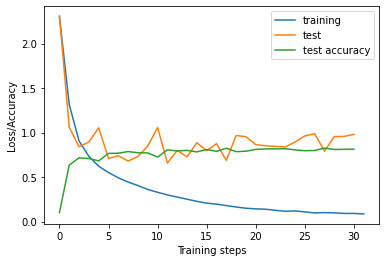

In [18]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()

### Training ResNet

In [9]:

### Hyperparameters
num_epochs = 30
learning_rate = 0.001

# Initialize the model.
model = ResNet(num_block = 3, channels_in_block = 256)  
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)


Block 1
n_channel: 256
n_filters: 64
Block 2
n_channel: 256
n_filters: 128
Block 3
n_channel: 256
n_filters: 256


In [10]:
@tf.function
def train_step(model, input, target, loss_function, optimizer, training=True):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape: #we safe the loss in the gradient tape 
    prediction = model(input, training)
    #Since we use L2 Regularization, we ensure that we take this penality score into account in our loss
    loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function, training=False):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input, training)
    #Since we use L2 Regularization, we ensure that we take this penality score into account in our loss
    sample_test_loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    #Comparing the ratio of rightly classified images by looking at the index with max. probability 
    sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss)
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
tf.keras.backend.clear_session()

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_data.take(1000)
test_dataset = test_data.take(100)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.0903125
Epoch: 1 starting with accuracy 0.29578125
Epoch: 2 starting with accuracy 0.4196875
Epoch: 3 starting with accuracy 0.3971875
Epoch: 4 starting with accuracy 0.3978125
Epoch: 5 starting with accuracy 0.36203125
Epoch: 6 starting with accuracy 0.31515625
Epoch: 7 starting with accuracy 0.5940625
Epoch: 8 starting with accuracy 0.50359375
Epoch: 9 starting with accuracy 0.4653125
Epoch: 10 starting with accuracy 0.55984375
Epoch: 11 starting with accuracy 0.59
Epoch: 12 starting with accuracy 0.428125
Epoch: 13 starting with accuracy 0.548125
Epoch: 14 starting with accuracy 0.63640625
Epoch: 15 starting with accuracy 0.5978125
Epoch: 16 starting with accuracy 0.511875
Epoch: 17 starting with accuracy 0.55078125
Epoch: 18 starting with accuracy 0.58296875
Epoch: 19 starting with accuracy 0.5425


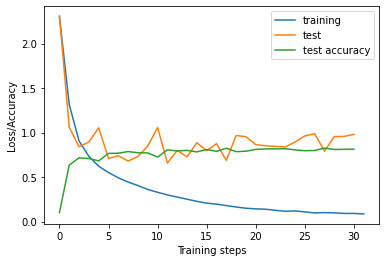

In [ ]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()